This notebook performs the synthesis using our proposed synthesization approach applied to the IPUMS data. The synthesis model is a CART. Logistic regression with three way interactions is used as the pMSE model.

In [1]:
from numpy.random import default_rng
import matplotlib.pyplot as plt
import itertools
import pickle

from sklearn.tree import DecisionTreeClassifier

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

# from bayesian_bootstrap import bayesian_bootstrap

from helper_functions import *

rng = np.random.RandomState(42)

Import the data.

In [2]:
# import standardized lat/long location data
train_data_original = pd.read_csv("../Data/IPUMS/non_normalized_cleaned_ipums_data.csv")
train_data_categorical = train_data_original.copy()

In [3]:
train_data_original

,incwage,years_of_educ,potential_experience,non_white,sex
0,11000,16.000000,18.000000,0,1
1,38000,15.000000,23.000000,0,0
2,7000,13.000000,2.000000,0,0
3,2600,11.000000,0.000000,0,0
4,20800,12.000000,33.000000,1,0
...,...,...,...,...,...
197751,22500,16.000000,13.000000,0,0
197752,4500,16.000000,11.000000,0,1
197753,37000,17.737673,19.262327,0,0
197754,1500,15.000000,13.000000,0,1


In [4]:
cat_columns = ['years_of_educ', 'potential_experience']
train_data_categorical[cat_columns] = train_data_categorical[cat_columns].apply(lambda x: x.astype('category'))
categories = train_data_categorical[cat_columns].apply(lambda x: x.cat.categories)
train_data_categorical[cat_columns] = train_data_categorical[cat_columns].apply(lambda x: x.cat.codes)

In [5]:
train_data_categorical

,incwage,years_of_educ,potential_experience,non_white,sex
0,11000,11,85,0,1
1,38000,10,115,0,0
2,7000,8,5,0,0
3,2600,6,0,0,0
4,20800,7,175,1,0
...,...,...,...,...,...
197751,22500,11,56,0,0
197752,4500,11,44,0,1
197753,37000,12,94,0,0
197754,1500,10,56,0,1


***

# Full Sequential Synthesis Driven by Bayesian Optimization

In [6]:
from scipy.stats import mode, iqr

def smooth(dtype, y_synth, y_real_min, y_real_max):
    indices = [True for _ in range(len(y_synth))]

    # exclude from smoothing if freq for a single value higher than 70%
    y_synth_mode = mode(y_synth)
    if y_synth_mode.count / len(y_synth) > 0.7:
        indices = np.logical_and(indices, y_synth != y_synth_mode.mode)

    # exclude from smoothing if data are top-coded - approximate check
    y_synth_sorted = np.sort(y_synth)
    top_coded = 10 * np.abs(y_synth_sorted[-2]) < np.abs(y_synth_sorted[-1]) - np.abs(y_synth_sorted[-2])
    if top_coded:
        indices = np.logical_and(indices, y_synth != y_real_max)

    # R version
    # http://www.bagualu.net/wordpress/wp-content/uploads/2015/10/Modern_Applied_Statistics_With_S.pdf
    # R default (ned0) - [link eq5.5 in p127] - this is used as the other one is not a closed formula
    # R recommended (SJ) - [link eq5.6 in p129]
    bw = 0.9 * len(y_synth[indices]) ** -1/5 * np.minimum(np.std(y_synth[indices]), iqr(y_synth[indices]) / 1.34)

    # # Python version - much slower as it's not a closed formula and requires a girdsearch
    # bandwidths = 10 ** np.linspace(-1, 1, 10)
    # grid = GridSearchCV(KernelDensity(kernel='gaussian'), {'bandwidth': bandwidths}, cv=3, iid=False)
    # grid.fit(y_synth[indices, None])
    # bw = grid.best_estimator_.bandwidth

    y_synth[indices] = np.array([np.random.normal(loc=value, scale=bw) for value in y_synth[indices]])
    if not top_coded:
        y_real_max += bw
    y_synth[indices] = np.clip(y_synth[indices], y_real_min, y_real_max)
    if dtype == 'int':
        y_synth[indices] = y_synth[indices].astype(int)

    return y_synth

Function for bayesian bootstrap.

In [7]:
# def stat(x):
#     return x

Write function to train all models and generate the synthetic dataset, then evaluate the pMSE ratio.

In [8]:
def train_models(#overall parameters
                 train_data_original,
                 train_data_categorical,
                 number_synthetic_datasets,
                 # hyperparameters for CART, end with underscore means Bayesian optimization will choose
                 mb_years_of_educ_,
                 mb_potential_experience_,
                 mb_non_white_,
                 mb_sex_):
    
    num_samples = train_data_original.shape[0]

    # generate and store number_synthetic_datasets synthetic datasets
    sXs = [pd.DataFrame(train_data_original.sample(frac=1.0, replace=True, ignore_index=True).loc[:,'incwage']) for x in range(number_synthetic_datasets)]

    # convert data type for compatability with smoothing function
    sXs = [X.astype('float64') for X in sXs]
    
    # apply smoothing to incwage
    for i in range(number_synthetic_datasets):
        sXs[i].loc[:,'incwage'] = smooth(dtype='float64', y_synth=sXs[i].incwage, y_real_min=np.min(train_data_original.incwage), y_real_max=np.max(train_data_original.incwage))
    
    ####################################################################################################

    ########### Code for years_of_educ CART ##########
    cart_years_of_educ = DecisionTreeClassifier(min_samples_leaf=mb_years_of_educ_, random_state=rng)

    new_index = train_data_original.sample(frac=1.0, replace=True).index
    
    cart_years_of_educ.fit(X=pd.DataFrame(train_data_original.loc[new_index,'incwage']), y=train_data_categorical.loc[new_index, 'years_of_educ'])
    
    node_indicators = cart_years_of_educ.decision_path(pd.DataFrame(train_data_original.loc[new_index,'incwage'])).toarray()
    
    node_outcomes = [train_data_categorical.loc[new_index, 'years_of_educ'][node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]

    # bst_vals = [bayesian_bootstrap(X=np.array(x), 
    #                                statistic=stat,
    #                                n_replications=1,
    #                                resample_size=len(x))[0] for x in node_outcomes]
    
    # sample synthetic values
    
    for i in range(number_synthetic_datasets):
        
        synth_leaves = cart_years_of_educ.apply(pd.DataFrame(sXs[i].loc[:, 'incwage']))
        
        new_years_of_educ = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_years_of_educ[synth_leaves==x] = rng.choice(node_outcomes[x], size=np.sum(synth_leaves==x))

        new_years_of_educ = categories['years_of_educ'][new_years_of_educ]
        
        new_years_of_educ = pd.Series(new_years_of_educ)
        
        new_years_of_educ.name = "years_of_educ"
        
        sXs[i] = pd.concat([sXs[i], new_years_of_educ], axis=1)

    ####################################################################################################

    ########### Code for potential_experience CART ##########
    cart_pot_exp = DecisionTreeClassifier(min_samples_leaf=mb_potential_experience_, random_state=rng)

    new_index = train_data_original.sample(frac=1.0, replace=True).index
    
    cart_pot_exp.fit(X=pd.DataFrame(train_data_original.loc[new_index,['incwage', 'years_of_educ']]), y=train_data_categorical.loc[new_index, 'potential_experience'])
    
    node_indicators = cart_pot_exp.decision_path(pd.DataFrame(train_data_original.loc[new_index,['incwage', 'years_of_educ']])).toarray()
    
    node_outcomes = [train_data_categorical.loc[new_index,'potential_experience'][node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]

    # bst_vals = [bayesian_bootstrap(X=np.array(x), 
    #                                statistic=stat,
    #                                n_replications=1,
    #                                resample_size=len(x))[0] for x in node_outcomes]
    
    # sample synthetic values
    
    for i in range(number_synthetic_datasets):
        
        synth_leaves = cart_pot_exp.apply(pd.DataFrame(sXs[i].loc[:, ['incwage', 'years_of_educ']]))
        
        new_pot_exp = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_pot_exp[synth_leaves==x] = rng.choice(node_outcomes[x], size=np.sum(synth_leaves==x))

        new_pot_exp = categories['potential_experience'][new_pot_exp]
        
        new_pot_exp = pd.Series(new_pot_exp)

        # apply smoothing to potential_experience

        new_pot_exp = pd.Series(smooth(dtype='float64', y_synth=new_pot_exp, y_real_min=np.min(train_data_original.potential_experience), y_real_max=np.max(train_data_original.potential_experience)))
        
        new_pot_exp.name = "potential_experience"
        
        sXs[i] = pd.concat([sXs[i], new_pot_exp], axis=1)

    ########### Code for non_white CART ##########
    cart_non_white = DecisionTreeClassifier(min_samples_leaf=mb_non_white_, random_state=rng)

    new_index = train_data_original.sample(frac=1.0, replace=True).index
    
    cart_non_white.fit(X=train_data_original.loc[new_index,['incwage', 'years_of_educ', 'potential_experience']], y=train_data_original.loc[new_index,"non_white"])
    
    node_indicators = cart_non_white.decision_path(train_data_original.loc[new_index,['incwage', 'years_of_educ', 'potential_experience']]).toarray()
    
    node_outcomes = [train_data_original.loc[new_index, 'non_white'][node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]

    # bst_vals = [bayesian_bootstrap(X=np.array(x), 
    #                                statistic=stat,
    #                                n_replications=1,
    #                                resample_size=len(x))[0] for x in node_outcomes]
    
    # sample values according to a Bayesian bootstrap
    
    for i in range(number_synthetic_datasets):
        
        synth_leaves = cart_non_white.apply(sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience']])
        
        new_non_white = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_non_white[synth_leaves==x] = rng.choice(node_outcomes[x], size=np.sum(synth_leaves==x))
        
        new_non_white = pd.Series(new_non_white)
        
        new_non_white.name = "non_white"
        
        sXs[i] = pd.concat([sXs[i], new_non_white], axis=1)
    
    ####################################################################################################
        
    ########### Code for sex CART ##########
    
    cart_sex = DecisionTreeClassifier(min_samples_leaf=mb_sex_, random_state=rng)

    new_index = train_data_original.sample(frac=1.0, replace=True).index
    
    cart_sex.fit(X=train_data_original.loc[new_index,['incwage', 'years_of_educ', 'potential_experience', 'non_white']], y=train_data_original.loc[new_index,"sex"])
    
    node_indicators = cart_sex.decision_path(train_data_original.loc[new_index,['incwage', 'years_of_educ', 'potential_experience', 'non_white']]).toarray()
    
    node_outcomes = [train_data_original.loc[new_index, 'sex'][node_indicators[:,x]==1] for x in np.arange(node_indicators.shape[1])]
    
    # sample values according to a Bayesian bootstrap

    # bst_vals = [bayesian_bootstrap(X=np.array(x), 
    #                                statistic=stat,
    #                                n_replications=1,
    #                                resample_size=len(x))[0] for x in node_outcomes]
    
    for i in range(number_synthetic_datasets):
        
        synth_leaves = cart_sex.apply(sXs[i].loc[:,['incwage', 'years_of_educ', 'potential_experience', 'non_white']])
        
        new_sex = np.zeros(len(synth_leaves), dtype=int)
        
        for j, x in enumerate(np.arange(node_indicators.shape[1])):
            
            new_sex[synth_leaves==x] = rng.choice(node_outcomes[x], size=np.sum(synth_leaves==x))
        
        new_sex = pd.Series(new_sex)
        
        new_sex.name = "sex"
        
        sXs[i] = pd.concat([sXs[i], new_sex], axis=1)
        
    ###### Calculate ks distances ######
    pmse_ratios = [pmse_ratio(train_data_original, Y) for Y in sXs]
    
    return pmse_ratios, sXs

In [9]:
def optimize_models(train_data_original,
                    train_data_categorical,
                    number_synthetic_datasets,
                    random_state):

    def evaluate_models(mb_non_white_, mb_sex_, mb_years_of_educ_, mb_potential_experience_):

        pmse_ratios, _ = train_models(train_data_original=train_data_original,
                                      train_data_categorical=train_data_categorical,
                                      number_synthetic_datasets=number_synthetic_datasets,
                                      mb_non_white_=int(mb_non_white_),
                                      mb_sex_=int(mb_sex_),
                                      mb_years_of_educ_=int(mb_years_of_educ_),
                                      mb_potential_experience_=int(mb_potential_experience_))

        return -1 * ((1 - np.mean(pmse_ratios))**2)

    optimizer = BayesianOptimization(
        f=evaluate_models,
        pbounds={
            "mb_non_white_": (10, 300.99),
            "mb_sex_": (10, 300.99),
            "mb_years_of_educ_": (10, 300.99),
            "mb_potential_experience_": (10, 300.99)
        },
        random_state=random_state)

    utility = UtilityFunction(kind="ei", xi=1e-02)
    optimizer.maximize(init_points=5, n_iter=25, acquisition_function=utility)
    print("Final Result: ", optimizer.max)
    return optimizer.max, optimizer

The default value of $\alpha = 1e-06$.

In [10]:
nsd = 10
random_states = [np.random.RandomState(1006), np.random.RandomState(428)]

In [11]:
optimization_results = [optimize_models(train_data_original=train_data_original,
                                        train_data_categorical=train_data_categorical,
                                        number_synthetic_datasets=nsd,
                                        random_state=r) for r in random_states]

|   iter    |  target   | mb_non... | mb_pot... |  mb_sex_  | mb_yea... |
-------------------------------------------------------------------------
| 1         | -0.008367 | 226.2     | 75.89     | 197.0     | 266.8     |
| 2         | -0.01275  | 225.5     | 219.9     | 95.94     | 162.9     |
| 3         | -0.01279  | 60.56     | 246.3     | 257.2     | 84.64     |
| 4         | -0.1227   | 79.03     | 143.4     | 76.61     | 68.78     |
| 5         | -0.2786   | 296.0     | 295.4     | 223.8     | 129.1     |
| 6         | -0.01288  | 154.0     | 221.2     | 206.6     | 268.0     |
| 7         | -0.1279   | 69.03     | 241.0     | 262.7     | 80.98     |
| 8         | -0.06968  | 100.7     | 285.7     | 263.5     | 155.0     |
| 9         | -0.0404   | 90.92     | 126.7     | 40.79     | 39.48     |
| 10        | -0.0301   | 216.4     | 69.12     | 47.47     | 198.7     |
| 11        | -0.1322   | 182.9     | 118.9     | 229.7     | 36.18     |
| 12        | -1.162    | 140.0     | 

***

In [12]:
run_targets = [np.minimum.accumulate(-i[1].space.target) for i in optimization_results]

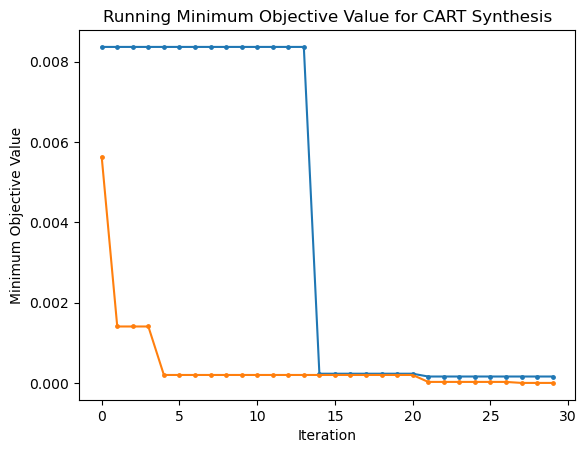

In [13]:
plt.plot(run_targets[0])
plt.scatter(np.arange(len(run_targets[0])), run_targets[0], s=6)
plt.plot(run_targets[1])
plt.scatter(np.arange(len(run_targets[1])), run_targets[1], s=6)
plt.title("Running Minimum Objective Value for CART Synthesis")
plt.xlabel("Iteration")
plt.ylabel("Minimum Objective Value")
plt.show()

Choose the params that gave the best objective value across all random seeds.

In [14]:
best_params = optimization_results[np.argmax([x[0]['target'] for x in optimization_results])][0]

In [15]:
best_params

{'target': -6.789977154123683e-07,
 'params': {'mb_non_white_': 290.6241658203894,
  'mb_potential_experience_': 298.9410846360685,
  'mb_sex_': 70.46658512566557,
  'mb_years_of_educ_': 217.2299193253915}}

***

Generate 20 synthetic datasets.

In [22]:
pmse_ratios, full_sXs = train_models(train_data_original=train_data_original,
                                     train_data_categorical=train_data_categorical,
                                     number_synthetic_datasets=20,
                                     mb_years_of_educ_=int(best_params['params']['mb_years_of_educ_']),
                                     mb_potential_experience_=int(best_params['params']['mb_potential_experience_']),
                                     mb_sex_=int(best_params['params']['mb_sex_']),
                                     mb_non_white_=int(best_params['params']['mb_non_white_']))

In [23]:
np.mean(pmse_ratios)

1.0752232635730627

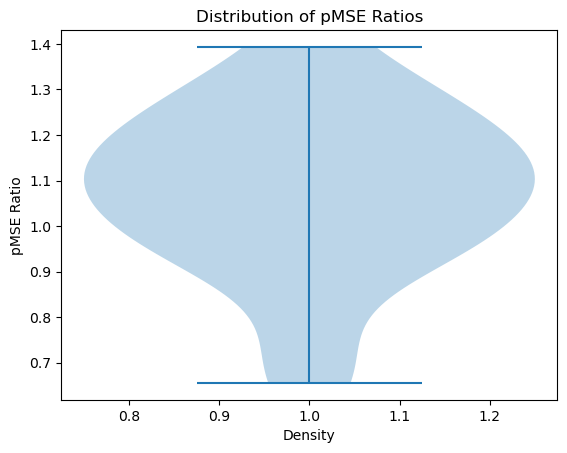

In [24]:
plt.violinplot(pmse_ratios)
plt.xlabel("Density")
plt.ylabel("pMSE Ratio")
plt.title("Distribution of pMSE Ratios")
plt.show()

***

# Save the synthetic datasets.

In [25]:
for i, sX in enumerate(full_sXs):
    sX.to_csv("../Data/IPUMS/Synthetic Datasets/cart_" + str(i) + ".csv", index=False)

***

In [ ]:
full_sXs = [pd.read_csv("../Data/IPUMS/Synthetic Datasets/gmm_and_cart_" + str(i) + ".csv") for i in range(20)]

In [ ]:
# load
with open('../Results/IPUMS/Models/gmm_and_cart.pkl', 'rb') as f:
    GMM = pickle.load(f)

***

Now apply the attribute disclosure prevention algorithm.

We don't have a great baseline for the probability of being non-white, so we'll just use the proportion from the data.

In [ ]:
prior = np.mean(train_data.non_white == 1)

For our threshold, we select $c = 10$, i.e., we are allowing for a 10x increase in the probability of an adversary inferring the non-white status based on the synthetic data. This is a relatively large increase. For example, this means going from XXX under the prior to no more than XXX under the updated probability.

In [ ]:
prior

In [ ]:
c = 3

We provide a range of $\delta$ values over which to evaluate and prevent attribute disclosure.

In [ ]:
deltas = np.linspace(0.001, 0.1, 3)

In [ ]:
ad_sXs = [attribute_disclosure_reduction(original_data=train_data, 
                                         synthetic_data=X,
                                         continuous_vars=['incwage', 'years_of_educ', 'potential_experience'],
                                         categorical_vars=['sex'],
                                         sensitive_var='non_white',
                                         mixture_model=GMM,
                                         deltas=deltas, 
                                         c=c, 
                                         prior_prob=prior) for X in full_sXs]

In [ ]:
for i, sX in enumerate(ad_sXs):
    sX.to_csv("../Data/IPUMS/Synthetic Datasets/ad_gmm_and_cart_" + str(i) + ".csv", index=False)

***